In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchmcr.synthetic.randomgaussians import generate_spectra
from torchmcr.basemodel import MCR
from torchmcr.simplemcr import NormalizedSpectraMCRModel, SimpleMCRModel
from torchmcr.train import train_mcr_model
from torchmcr.loss_models.smooth_loss import create_smooth_loss
from torchmcr.loss_models.loss_registry import MCRLossRegistry
from torchmcr.spectrainit import simplisma
from torchmcr.utils.domain_constraints import inverse_normalized_softmax, normalized_softmax, inverse_softplus


import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

In [2]:
waves, data = generate_spectra(3, 10, amplitude_limits=[1,2], variance_limits=[20,40])
print(data.shape)
norma = np.sum(data, axis=-1)
data = 1000*data/norma[:,None]
print(data.shape)
times = np.linspace(0,1,1000)
weights = np.vstack( [np.exp(-(times-0.1)**2/(2.0*0.05**2)),
                      np.exp(-(times-0.5)**2/(2.0*0.07**2)),
                      np.exp(-(times-0.85)**2/(2.0*0.05**2)),
                     ]
                   ).T


(3, 1000)
(3, 1000)


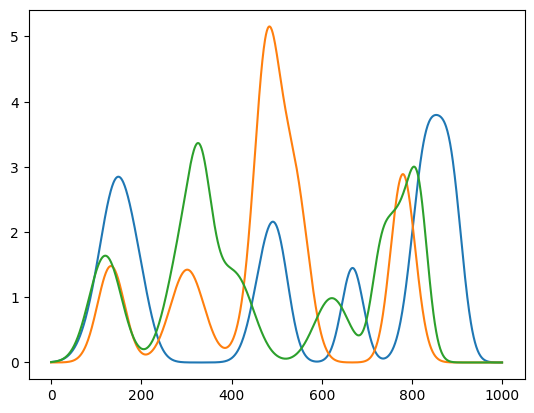

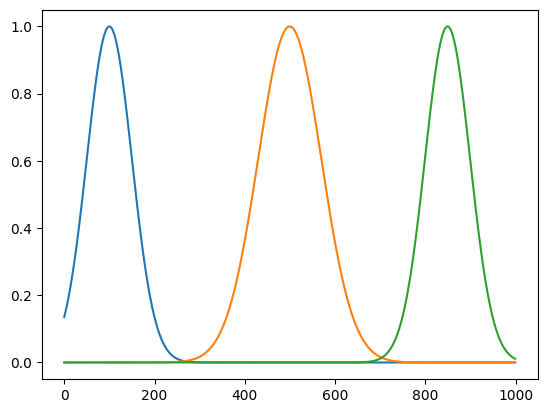

In [3]:
for s in data:
    plt.plot(waves, s)
plt.show()
for tmp in weights.T:
    plt.plot(tmp)
plt.show()

In [4]:
data = torch.Tensor(data)
weights = torch.Tensor(weights)

torch.Size([1000, 1000])


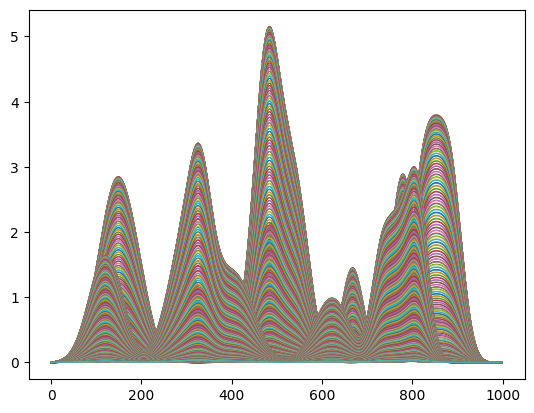

In [5]:
reference_mcr = SimpleMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            preload_weights=weights,
                            preload_spectra=data
                           )
reference_mcr.freeze_spectra()
reference_mcr.freeze_weights()
# Forward pass without additional arguments
observed_data = reference_mcr().detach()
print(observed_data.shape)

for s in observed_data:
    plt.plot(s.detach().numpy(), lw=0.8)
plt.show()



In [6]:
trial1_mcr = NormalizedSpectraMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            preload_weights=weights,
                            preload_spectra=None, 
                           )

trial1_mcr.freeze_weights()

In [7]:
# First create the loss registry with desired weights
loss_registry = create_smooth_loss(
    base_loss_fn=F.l1_loss,
    smooth_spectra_weight=0.0,
    smooth_weight_weight=0.0,
    weight_cross_product_weight=0.0
)

# Then use it in training with a lambda function
train_mcr_model(
    trial1_mcr, 
    observed_data, 
    num_epochs=1000, 
    mini_epochs=5, 
    lr=0.001, 
    tolerance=1e-12,
    optimizer_class=torch.optim.Adam, 
    loss_fn=lambda predicted, target: loss_registry.compute_total_loss(
        trial1_mcr,
        predicted=predicted,
        target=target,
        spectra_kwargs={},
        weights_kwargs={}
    )[0],  # Note the [0] to get just the total loss value
    device="cpu"
)

Epoch 1/1000, Loss: 0.078724
Epoch 11/1000, Loss: 0.074864
Epoch 21/1000, Loss: 0.071009
Epoch 31/1000, Loss: 0.067169
Epoch 41/1000, Loss: 0.063387
Epoch 51/1000, Loss: 0.059688
Epoch 61/1000, Loss: 0.056049
Epoch 71/1000, Loss: 0.052530
Epoch 81/1000, Loss: 0.049120
Epoch 91/1000, Loss: 0.045845
Epoch 101/1000, Loss: 0.042729
Epoch 111/1000, Loss: 0.039776
Epoch 121/1000, Loss: 0.036997
Epoch 131/1000, Loss: 0.034391
Epoch 141/1000, Loss: 0.031939
Epoch 151/1000, Loss: 0.029637
Epoch 161/1000, Loss: 0.027490
Epoch 171/1000, Loss: 0.025494
Epoch 181/1000, Loss: 0.023637
Epoch 191/1000, Loss: 0.021931
Epoch 201/1000, Loss: 0.020363
Epoch 211/1000, Loss: 0.018933
Epoch 221/1000, Loss: 0.017621
Epoch 231/1000, Loss: 0.016424
Epoch 241/1000, Loss: 0.015331
Epoch 251/1000, Loss: 0.014334
Epoch 261/1000, Loss: 0.013425
Epoch 271/1000, Loss: 0.012590
Epoch 281/1000, Loss: 0.011819
Epoch 291/1000, Loss: 0.011111
Epoch 301/1000, Loss: 0.010460
Epoch 311/1000, Loss: 0.009856
Epoch 321/1000, Los

In [8]:
recovered_spectra = trial1_mcr.spectra().clone()

In [9]:
recovered_weights = trial1_mcr.weights().clone()

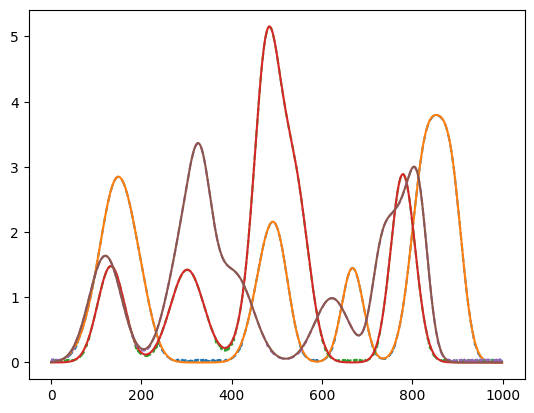

In [10]:
for s, ss in zip(recovered_spectra, data):
    plt.plot(s.detach().cpu().numpy(), '--')
    plt.plot(ss.cpu().numpy(), )

In [11]:


import torch
import torch.nn.functional as F

loss_registry = create_smooth_loss(
    base_loss_fn=F.l1_loss,
    smooth_spectra_weight=1.0,
    smooth_weight_weight=1.0,
    weight_cross_product_weight=0.01
)


trial2_mcr = NormalizedSpectraMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            preload_weights=None,
                            preload_spectra=data,
                            weights_modifier=torch.nn.Softplus()
                           )
trial2_mcr.freeze_spectra()


# Then use it in training with a lambda function
train_mcr_model(
    trial2_mcr, 
    observed_data, 
    num_epochs=1000, 
    mini_epochs=5, 
    lr=0.05, 
    tolerance=1e-12,
    optimizer_class=torch.optim.Adam, 
    loss_fn=lambda predicted, target: loss_registry.compute_total_loss(
        trial2_mcr,
        predicted=predicted,
        target=target,
        spectra_kwargs={},
        weights_kwargs={}
    )[0],  # Note the [0] to get just the total loss value
    device="cpu"
)

Epoch 1/1000, Loss: 0.447827
Epoch 11/1000, Loss: 0.080844
Epoch 21/1000, Loss: 0.033921
Epoch 31/1000, Loss: 0.020978
Epoch 41/1000, Loss: 0.015501
Epoch 51/1000, Loss: 0.012636
Epoch 61/1000, Loss: 0.010933
Epoch 71/1000, Loss: 0.009832
Epoch 81/1000, Loss: 0.009070
Epoch 91/1000, Loss: 0.008516
Epoch 101/1000, Loss: 0.008094
Epoch 111/1000, Loss: 0.007770
Epoch 121/1000, Loss: 0.007512
Epoch 131/1000, Loss: 0.007304
Epoch 141/1000, Loss: 0.007135
Epoch 151/1000, Loss: 0.006993
Epoch 161/1000, Loss: 0.006873
Epoch 171/1000, Loss: 0.006771
Epoch 181/1000, Loss: 0.006685
Epoch 191/1000, Loss: 0.006608
Epoch 201/1000, Loss: 0.006541
Epoch 211/1000, Loss: 0.006483
Epoch 221/1000, Loss: 0.006431
Epoch 231/1000, Loss: 0.006386
Epoch 241/1000, Loss: 0.006343
Epoch 251/1000, Loss: 0.006306
Epoch 261/1000, Loss: 0.006275
Epoch 271/1000, Loss: 0.006242
Epoch 281/1000, Loss: 0.006216
Epoch 291/1000, Loss: 0.006189
Epoch 301/1000, Loss: 0.006166
Epoch 311/1000, Loss: 0.006146
Epoch 321/1000, Los

In [12]:
recovered_weights = trial2_mcr.weights().clone()

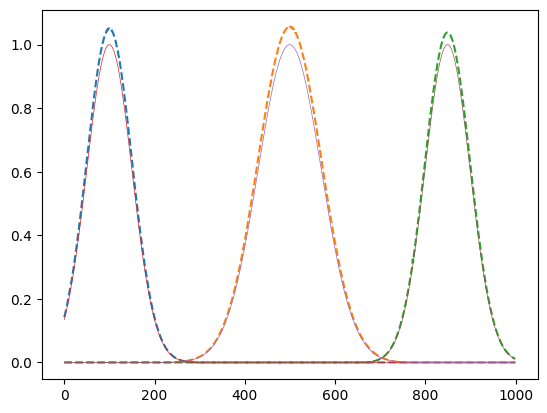

In [13]:
t = np.arange(100)
plt.plot(recovered_weights[:,0].detach().cpu().numpy(), "--", )
plt.plot(recovered_weights[:,1].detach().cpu().numpy(), "--")
plt.plot(recovered_weights[:,2].detach().cpu().numpy(), "--")
plt.plot(weights[:,0].detach().cpu().numpy(), lw=.5)
plt.plot(weights[:,1].detach().cpu().numpy(), lw=.5)
plt.plot(weights[:,2].detach().cpu().numpy(), lw=.5)


In [14]:
from torchmcr.spectrainit import simplisma

In [15]:
start_spectra = simplisma(observed_data, 3)

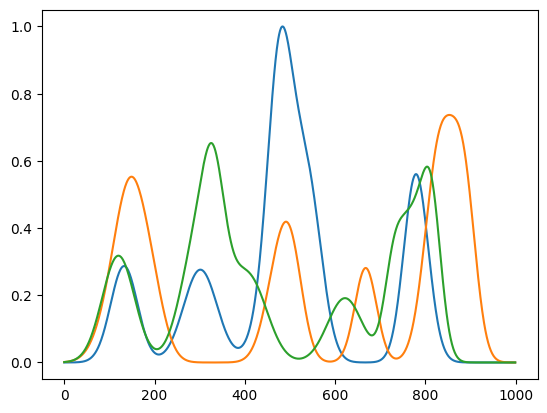

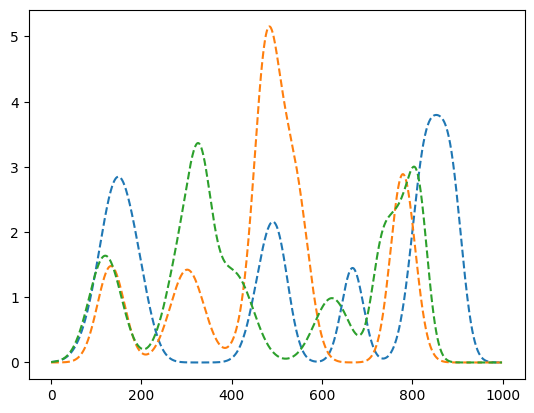

In [16]:
plt.plot(start_spectra[0])
plt.plot(start_spectra[1])
plt.plot(start_spectra[2])
plt.show()
plt.plot(data[0], "--")
plt.plot(data[1], "--")
plt.plot(data[2], "--")
plt.show()

In [17]:
trial3_mcr = NormalizedSpectraMCRModel(M_samples=weights.shape[0], 
                            K_components=3, 
                            N_waves=data.shape[-1],
                            preload_weights=None,
                            preload_spectra=start_spectra,
                            weights_modifier=torch.nn.Softplus())


In [24]:
weights = [0,10, 0.0]
for w in weights:
    loss_registry = create_smooth_loss(
        base_loss_fn=F.l1_loss,
        smooth_spectra_weight=0.0,
        smooth_weight_weight=0.0,
        weight_cross_product_weight=w
    )

    train_mcr_model(trial3_mcr, 
                    observed_data, 
                    num_epochs=500, 
                    mini_epochs=30, 
                    lr=0.01, 
                    tolerance=1e-6, 
                    optimizer_class=torch.optim.Adam, 
                    loss_fn=lambda predicted, target: loss_registry.compute_total_loss(
                        trial3_mcr,
                        predicted=predicted,
                        target=target,
                        spectra_kwargs={},
                        weights_kwargs={})[0],  # Note the [0] to get just the total loss value
                    device="cpu")

    train_mcr_model(trial3_mcr, 
                    observed_data, 
                    num_epochs=500, 
                    mini_epochs=3, 
                    lr=0.001, 
                    tolerance=1e-15, 
                    optimizer_class=torch.optim.Adam, 
                    loss_fn=lambda predicted, target: loss_registry.compute_total_loss(
                        trial3_mcr,
                        predicted=predicted,
                        target=target,
                        spectra_kwargs={},
                        weights_kwargs={})[0],  # Note the [0] to get just the total loss value
                    device="cpu")



Epoch 1/500, Loss: 0.000025
Early stopping: Loss change below tolerance.
Epoch 1/500, Loss: 0.000187
Epoch 11/500, Loss: 0.000057
Epoch 21/500, Loss: 0.000047
Epoch 31/500, Loss: 0.000046
Epoch 41/500, Loss: 0.000046
Epoch 51/500, Loss: 0.000046
Epoch 61/500, Loss: 0.000046
Epoch 71/500, Loss: 0.000046
Epoch 81/500, Loss: 0.000046
Epoch 91/500, Loss: 0.000046
Epoch 101/500, Loss: 0.000046
Epoch 111/500, Loss: 0.000046
Epoch 121/500, Loss: 0.000046
Epoch 131/500, Loss: 0.000046
Epoch 141/500, Loss: 0.000047
Epoch 151/500, Loss: 0.000047
Epoch 161/500, Loss: 0.000047
Epoch 171/500, Loss: 0.000047
Epoch 181/500, Loss: 0.000047
Epoch 191/500, Loss: 0.000047
Epoch 201/500, Loss: 0.000047
Epoch 211/500, Loss: 0.000047
Epoch 221/500, Loss: 0.000046
Epoch 231/500, Loss: 0.000046
Epoch 241/500, Loss: 0.000046
Epoch 251/500, Loss: 0.000046
Epoch 261/500, Loss: 0.000046
Epoch 271/500, Loss: 0.000046
Epoch 281/500, Loss: 0.000046
Epoch 291/500, Loss: 0.000046
Epoch 301/500, Loss: 0.000046
Epoch 31

In [25]:
with torch.no_grad():
    www = trial3_mcr.weights.forward().clone().cpu().numpy()
    sss = trial3_mcr.spectra.forward().clone().cpu().numpy()
    
    

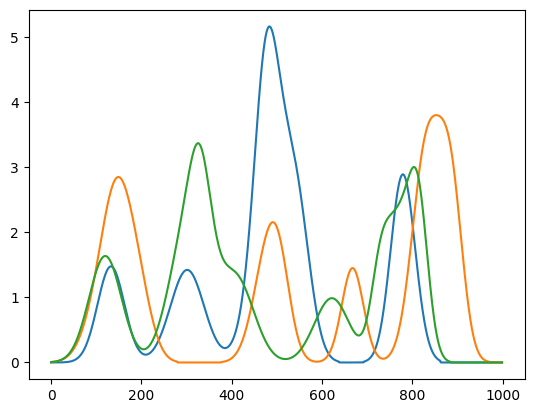

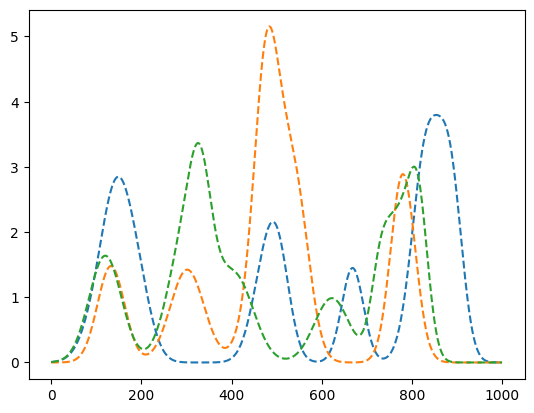

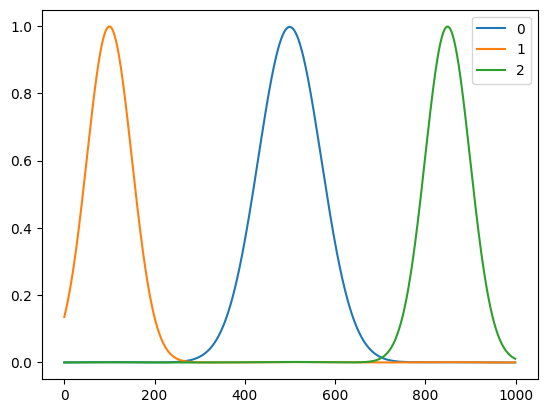

In [26]:
plt.plot(sss[0,...])
plt.plot(sss[1,...])
plt.plot(sss[2,...])
plt.show()
for s in data:
    plt.plot(waves, s, '--')
plt.show()

plt.plot(www[:,0])
plt.plot(www[:,1])
plt.plot(www[:,2])
plt.legend(range(3))

plt.show()
